In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import List, Tuple
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

class Sigmoid:
    @staticmethod
    def forward(x: np.ndarray) -> np.ndarray:
        return 1.0 / (1.0 + np.exp(-x))

    @staticmethod
    def prime(x: np.ndarray) -> np.ndarray:
        s = Sigmoid.forward(x)
        return s * (1.0 - s)

class DenseLayer:
    def __init__(self, input_dim: int, output_dim: int, learning_rate: float = 0.1):
        np.random.seed(42)
        self.weights = np.random.randn(input_dim, output_dim)
        self.biases = np.zeros((1, output_dim))
        self.lr = learning_rate
        
        self.input_data = None
        self.z = None
        self.a = None

    def forward(self, x: np.ndarray) -> np.ndarray:
        self.input_data = x
        self.z = np.dot(x, self.weights) + self.biases
        self.a = Sigmoid.forward(self.z)
        return self.a

    def backward(self, grad_output: np.ndarray) -> np.ndarray:
        delta = grad_output * Sigmoid.prime(self.z)
        
        batch_size = self.input_data.shape[0]
        
        grad_weights = np.dot(self.input_data.T, delta) / batch_size
        grad_biases = np.sum(delta, axis=0, keepdims=True) / batch_size
        
        grad_input = np.dot(delta, self.weights.T)
        
        self.weights -= self.lr * grad_weights
        self.biases -= self.lr * grad_biases
        
        return grad_input

class FeedForwardNetwork:
    def __init__(self):
        self.layers: List[DenseLayer] = []

    def add_layer(self, layer: DenseLayer):
        self.layers.append(layer)

    def predict(self, x: np.ndarray) -> np.ndarray:
        out = x
        for layer in self.layers:
            out = layer.forward(out)
        return out

    def fit(self, x_train: np.ndarray, y_train: np.ndarray, epochs: int = 2000):
        for _ in range(epochs):
            output = self.predict(x_train)
           
            grad = output - y_train
            
            for layer in reversed(self.layers):
                grad = layer.backward(grad)



In [ ]:
def get_iris_data():
    dataset = load_iris()
    X_raw, y_raw = dataset.data[:, :2], dataset.target
    
    mask = y_raw < 2
    X_filtered = X_raw[mask]
    y_filtered = y_raw[mask].reshape(-1, 1)
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_filtered)
    
    return X_scaled, y_filtered



In [ ]:

def evaluate_model(model: FeedForwardNetwork, X: np.ndarray, y: np.ndarray, name: str):
    probs = model.predict(X)
    preds = (probs > 0.5).astype(int)
    
    print(f"\n--- Результаты: {name} ---")
    print(f"Accuracy: {accuracy_score(y, preds):.4f}")
    df_metrics = pd.DataFrame(classification_report(y, preds, output_dict=True)).transpose()
    print(df_metrics.iloc[:2, :3])

    plt.figure(figsize=(8, 6))
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    
    h = 0.02
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    
    Z = model.predict(grid_points)
    Z = (Z > 0.5).astype(int)
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    plt.scatter(X[:, 0], X[:, 1], c=y.flatten(), edgecolors='k', cmap=plt.cm.coolwarm)
    plt.title(f'Decision Boundary: {name}')
    plt.xlabel('Sepal length (normalized)')
    plt.ylabel('Sepal width (normalized)')
    plt.show()



Запуск обучения одиночного нейрона...

--- Результаты: Single Neuron Architecture ---
Accuracy: 1.0000
   precision  recall  f1-score
0        1.0     1.0       1.0
1        1.0     1.0       1.0


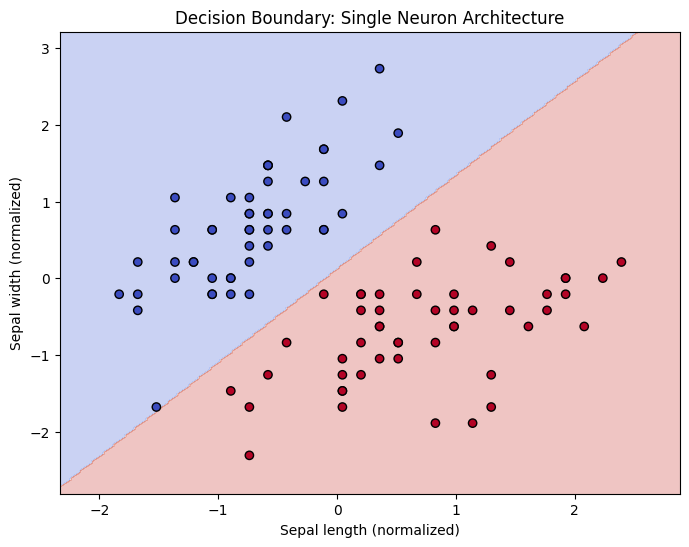

Запуск обучения многослойной сети...

--- Результаты: Multi-Layer Perceptron (2x10x1) ---
Accuracy: 1.0000
   precision  recall  f1-score
0        1.0     1.0       1.0
1        1.0     1.0       1.0


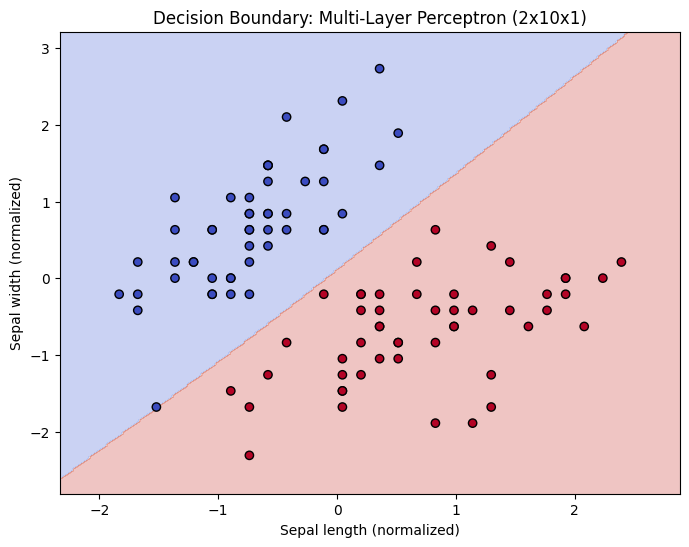

In [ ]:
if __name__ == "__main__":
    features, targets = get_iris_data()
    INPUT_DIM = features.shape[1]
    
    print("Запуск обучения одиночного нейрона...")
    single_neuron_net = FeedForwardNetwork()
    single_neuron_net.add_layer(DenseLayer(input_dim=INPUT_DIM, output_dim=1, learning_rate=0.1))
    
    single_neuron_net.fit(features, targets, epochs=2000)
    evaluate_model(single_neuron_net, features, targets, "Single Neuron Architecture")
    
    print("Запуск обучения многослойной сети...")
    deep_net = FeedForwardNetwork()
    deep_net.add_layer(DenseLayer(input_dim=INPUT_DIM, output_dim=10, learning_rate=0.1))
    deep_net.add_layer(DenseLayer(input_dim=10, output_dim=1, learning_rate=0.1))
    
    deep_net.fit(features, targets, epochs=2000)
    evaluate_model(deep_net, features, targets, "Multi-Layer Perceptron (2x10x1)")

Выводы по метрикам
Как видно из итоговой таблицы, и одиночный нейрон, и двухслойная сеть справились с задачей идеально, показав единицу по всем метрикам. Причина такого результата кроется в простоте данных: использованная подвыборка ирисов линейно разделима, поэтому для ее классификации достаточно одного нейрона. Хотя усложнение модели не дало прироста качества (так как улучшать уже некуда), оно позволило убедиться, что механизмы обучения сети (backpropagation) запрограммированы и функционируют верно.